In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
import numpy as np
from sympy import Matrix
import re

def parse_op(op_str):
    """Parse a symmetry operation string like 'x+1/2,-y,z+1/4'."""
    parts = op_str.split(',')
    xyz = parts
    rot = np.zeros((3, 3), dtype=int)
    trans = np.zeros(3)
    basis = {'x': [1, 0, 0], 'y': [0, 1, 0], 'z': [0, 0, 1]}
    for i, expr in enumerate(xyz):
        for var, vec in basis.items():
            if var in expr:
                sign = -1 if '-' + var in expr else 1
                rot[i] += sign * np.array(vec)
        match = re.search(r'([+-]?\d+)/(\d+)', expr)
        if match:
            trans[i] = float(match.group(1)) / float(match.group(2))
    return rot, trans

def parse_atomic_pos(atomic_pos_str, pos_format=[0,2,3,4]):
    element=atomic_pos_str[pos_format[0]]
    x=float(atomic_pos_str[pos_format[1]].split('(')[0])
    y=float(atomic_pos_str[pos_format[2]].split('(')[0])
    z=float(atomic_pos_str[pos_format[3]].split('(')[0])
    return element, np.array([x,y,z])

def get_symmetrized_atomic_positions(atomic_positions, symmetries):
    '''take atomic positions in tuple format (element, number, np array coordinates) and symmetry operations in
    matrix form and returns atomic positions in a dict: element: list of np arrays of coordinates.'''
    full_positions = {}
    i=0
    for atom in atomic_positions:
        element_positions=[]
        element, position_vector = atom
        for rot, trans in symmetries:
            op = make_symmetry_operation(rot, trans, 1, do_translation=True)
            new_pos = op(position_vector) % 1.0  # wrap into unit cell
            element_positions.append(np.array(np.round(new_pos, decimals=5)))
    
        # Remove duplicates
        unique_element_positions = [np.array(t) for t in set(tuple(element_position) for element_position in element_positions)]
        print('found positions of {} atoms!'.format(element))
        print(unique_element_positions)
        if element in full_positions:
            # This is needed because sometimes structures have multiple elemental positions that aren't symmetry related (e.g. O for LFO)
            i+=1
            full_positions[element+str(i)]=unique_element_positions
        else:
            full_positions[element]=unique_element_positions
    return full_positions

def label_AF_spin_by_distance_order(distances):
    ''' Takes a list of distances (not in order) and labels alternating distances opposite spins. Returns a list
    one element longer than the input distances (since distances are assumed to be measure relative to the first position)'''
    if not type(distances)==list:
        return [1,-1]
    else:
        sorted_indices = np.argsort(distances)
        sorted_distance_scores=np.array(distances)[sorted_indices]

        current_mag_sign=-1
        signs=[]
        previous_distance_score=sorted_distance_scores[0]
        for distance_score in sorted_distance_scores:
            if distance_score > previous_distance_score:
                current_mag_sign= current_mag_sign*-1
            signs.append(current_mag_sign)
            previous_distance_score=distance_score

        signs_in_order=np.empty_like(signs)
        for i, idx in enumerate(sorted_indices):
            signs_in_order[idx] = signs[i]

        mangetic_labels=np.insert(signs_in_order,0,1)
        return mangetic_labels
    
def label_magnetic_sublattices(full_atomic_positions,unit_cell_params, antiferromagnetism_type,magnetic_element):
    # for now we assume all angles= 90 deg
    unit_cell_matrix = np.array([unit_cell_params['a'],unit_cell_params['b'],unit_cell_params['c']])

    num_magnetic=len(full_atomic_positions[magnetic_element])

    atomic_positions_angstrom=[unit_cell_matrix * atomic_position for atomic_position in full_atomic_positions[magnetic_element]]
    a0_position=atomic_positions_angstrom[0]

    if antiferromagnetism_type=='G':
        # Antiferromagnetic in all directions (all NN opposite)
        distance_scores=[]
        for i in range(num_magnetic-1):
            distance_from_ao=np.linalg.norm(a0_position-atomic_positions_angstrom[i+1])
            distance_scores.append(np.round(distance_from_ao/0.2))
        mangetic_labels=label_AF_spin_by_distance_order(distance_scores)

    elif 'C_' in antiferromagnetism_type:
        # Ferromagnetic along the specified axis
        in_af_plane_distance_scores=[]
        direction=antiferromagnetism_type.split('_')[-1]
        direction_idx='abcxyz'.index(direction.lower()) % 3
        af_indecies=[0,1,2]
        af_indecies.remove(direction_idx)
        for i in range(num_magnetic-1):
            distance_from_ao_in_plane=np.linalg.norm(a0_position[af_indecies]-atomic_positions_angstrom[i+1][af_indecies])
            in_af_plane_distance_scores.append(np.round(distance_from_ao_in_plane/0.2))
        mangetic_labels=label_AF_spin_by_distance_order(distance_from_ao_in_plane)

    elif 'A_' in antiferromagnetism_type:
        # Antiferromagnetic along the specified axis
        in_af_plane_distance_scores=[]
        direction=antiferromagnetism_type.split('_')[-1]
        direction_idx='abcxyz'.index(direction.lower()) % 3
        for i in range(num_magnetic-1):
            distance_from_ao_in_plane=np.linalg.norm(a0_position[direction_idx]-atomic_positions_angstrom[i+1][direction_idx])
            in_af_plane_distance_scores.append(np.round(distance_from_ao_in_plane/0.2))
        mangetic_labels=label_AF_spin_by_distance_order(distance_from_ao_in_plane)


    return full_atomic_positions[magnetic_element], mangetic_labels

def read_cif_file(filename):
    # The CIF file format I'm using is the one you get from materialsproject when you download the "symmetrized" option.
    symmetry_operations_started=False
    symmetry_operations=[]
    atomic_positions_started=False
    atomic_positions_indexing_started=False
    atomic_positions_idxs=[0,2,3,4]
    atomic_positions=[]
    unit_cell_params={}
    with open(filename) as f:
        for line in f:
            if not symmetry_operations_started and not atomic_positions_started:
                if '_symmetry_equiv_pos_as_xyz' in line:
                    print('found symmetry operations block in CIF!')
                    symmetry_operations_started=True
                elif atomic_positions_indexing_started:
                    if 'atom_site_type_symbol' in line:
                        atomic_positions_idxs[0]=atomic_label_index
                    elif 'atom_site_fract_x' in line:
                        atomic_positions_idxs[1]=atomic_label_index
                    elif 'atom_site_fract_y' in line:
                        atomic_positions_idxs[2]=atomic_label_index
                    elif 'atom_site_fract_z' in line:
                        atomic_positions_idxs[3]=atomic_label_index
                    elif not '_' in line:
                        atomic_positions_indexing_started=False
                        atomic_positions_started=True
                        atom_pos=list(filter(None,line.split('\n')[0].split(' ')))
                        atomic_positions.append(parse_atomic_pos(atom_pos,pos_format=atomic_positions_idxs))
                    atomic_label_index+=1
                elif '_cell_length_a' in line:
                    unit_cell_params['a']=float(line.split('  ')[-1].split('(')[0])
                elif '_cell_length_b' in line:
                    unit_cell_params['b']=float(line.split('  ')[-1].split('(')[0])
                elif '_cell_length_c' in line:
                    unit_cell_params['c']=float(line.split('  ')[-1].split('(')[0])
                elif '_cell_angle_alpha' in line:
                    unit_cell_params['alpha']=float(line.split('  ')[-1].split('(')[0])
                elif '_cell_angle_beta' in line:
                    unit_cell_params['beta']=float(line.split('  ')[-1].split('(')[0])
                elif '_cell_angle_gamma' in line:
                    unit_cell_params['gamma']=float(line.split('  ')[-1].split('(')[0])
            else:
                if symmetry_operations_started:
                    if 'loop' in line:
                        symmetry_operations_started=False
                        atomic_positions_indexing_started=True
                        atomic_label_index=0
                    else:
                        line=line.split(' ')[-1]
                        line=line.replace("'",' ')
                        sym_ops="".join(line.split())
                        symmetry_operations.append(parse_op(sym_ops))
                elif atomic_positions_started:
                    if (line == '\n') or ('loop' in line):
                        atomic_positions_started=False
                        break
                    else:
                        atom_pos=list(filter(None,line.split('\n')[0].split(' ')))
                        atomic_positions.append(parse_atomic_pos(atom_pos,pos_format=atomic_positions_idxs))
    return symmetry_operations, atomic_positions, unit_cell_params

def remove_duplicate_operations(ops, tol=1e-2):
    seen = set()
    unique_ops = []

    for R, t in ops:
        # Round to avoid floating-point precision issues, then convert to tuple
        R_key = tuple(map(tuple, np.round(R / tol) * tol))
        t_key = tuple(np.round(t / tol) * tol)
        key = (R_key, t_key)

        if key not in seen:
            seen.add(key)
            unique_ops.append((R, t))

    return unique_ops

def get_MSG_antiunitary(atomic_positions, unit_cell_params, symmetries, magnetic_ordering, magnetic_element):
    '''Constructs a Magnetic Space Group given atomic positions, unit cell (required to find the nearness of neighbors), symmetries,
    and ordering. Returns matrix style antiunitary symmetries of the Magnetic Space Group. Note that this kind of Magnetic Space Group
    is the one where spatial operations like mirror and rotation do not affect the spin orientation, only time reversal.'''
    full_atomic_positions=get_symmetrized_atomic_positions(atomic_positions,symmetries)
    magnetic_positions, magnetic_labels=label_magnetic_sublattices(full_atomic_positions,unit_cell_params, magnetic_ordering,magnetic_element)
    antiunitary_symmetries=[]
    for symmetry in symmetries:
        op= make_symmetry_operation(*symmetry,1,do_translation=True)
        for i in range(len(magnetic_positions)):
            magnetic_position=magnetic_positions[i]
            magnetic_label=magnetic_labels[i]
            # this tries to find the index of the matching coordinates, but returns an index of -1 if it's not found
            index_of_position_match=next((i for i, a in enumerate(magnetic_positions) if np.array_equal(np.round(a,decimals=1),
                                                                                                        np.round((op(magnetic_position) % 1.0),decimals=1),0.2)),-1) 
            if index_of_position_match == -1:
                print('WARNING: no symmetry match!')
            if magnetic_label != magnetic_labels[index_of_position_match]:
                antiunitary_symmetries.append(symmetry)
    return remove_duplicate_operations(antiunitary_symmetries)
            

def get_k_sphere(n_points):
    # Get an array of n_points on a sphere of radius 1
    # shape (n_points)
    n_theta=int(np.sqrt(n_points)*np.sqrt(2))
    n_phi=int(n_points/n_theta)
    thetas = np.linspace(0, 2*np.pi, n_theta)
    phis = np.linspace(0, np.pi, n_phi)
    theta_grid, phi_grid = np.meshgrid(thetas, phis)
    xgrid=np.sin(phi_grid) * np.cos(theta_grid)
    ygrid=np.sin(phi_grid) * np.sin(theta_grid)
    zgrid = np.cos(phi_grid)
    
    points = np.stack([xgrid, ygrid, zgrid], axis=-1).reshape(-1, 3)  # Shape (N, 3)
    return points,xgrid,ygrid,zgrid,theta_grid,phi_grid

def make_symmetry_operation(rotation,translation,time_reversal, do_translation=False):
    def sym_op(p):
        if not do_translation:
            return (rotation*time_reversal) @ p
        else:
            return (rotation*time_reversal) @ p + translation
    return sym_op

def minimal_invariant_distance(k_transformed, k):
    delta = k_transformed - k
    # Check all possible G vectors within [-1,0,1] in each dimension to find minimal distance
    min_dist = np.inf
    for nx in [-1, 0, 1]:
        for ny in [-1, 0, 1]:
            for nz in [-1, 0, 1]:
                G = np.array([nx, ny, nz])
                dist = np.linalg.norm(delta - G)
                if dist < min_dist:
                    min_dist = dist
    min_dist= np.linalg.norm(delta)
    return min_dist
    
def score_invariantness_points(k_points,symmetry_operations):
    distances_from_invariant=[]

    for k_point in k_points:
        distance_from_invariant=np.inf
        for symmetry_operation in symmetry_operations.values():
            k_point_symmetry=symmetry_operation(k_point)
            if (dist:=minimal_invariant_distance(k_point_symmetry,k_point))<distance_from_invariant:
                distance_from_invariant=dist
        distances_from_invariant.append(distance_from_invariant)
    return np.array(distances_from_invariant)

def plot_plane_cut(xs, ys, zs, hkl, thickness=0.1):
    # Flatten points
    x = xs.ravel()
    y = ys.ravel()
    z = zs.ravel()
    points = np.stack([x, y, z], axis=1)

    # Normalize normal vector
    normal = np.array(hkl, dtype=float)
    normal /= np.linalg.norm(normal)

    # Project points onto plane
    dist = points @ normal
    mask = np.abs(dist) < thickness
    cut_points = points[mask]

    # Define 2D basis vectors in the plane
    if not np.allclose(normal, [1, 0, 0]):
        ref = np.array([1, 0, 0])
    else:
        ref = np.array([0, 1, 0])
    u = np.cross(normal, ref)
    u /= np.linalg.norm(u)
    v = np.cross(normal, u)

    # Project to 2D
    u_coords = cut_points @ u
    v_coords = cut_points @ v

    # Attempt to label axes in Miller-index style
    def miller_label(vec):
        print(vec)
        vec = np.round(vec, decimals=4)
        denom = np.lcm.reduce([int(1 / abs(i)) if i != 0 else 1 for i in vec])
        ints = (vec * denom).astype(int)
        def fmt(i): return f"{abs(i)}" if abs(i) != 1 else ""
        def sign(i): return "-" if i < 0 else ""
        return f"[{sign(ints[0])}{fmt(ints[0])}{sign(ints[1])}{fmt(ints[1])}{sign(ints[2])}{fmt(ints[2])}]"

    u_label = miller_label(u)
    v_label = miller_label(v)
    plane_label = f"({hkl[0]}{hkl[1]}{hkl[2]})"

    # Plot
    plt.figure(figsize=(5, 5))
    plt.scatter(u_coords, v_coords, s=1, color='black')
    plt.gca().set_aspect('equal')
    plt.title(f"Plane cut normal to {plane_label}")
    plt.xlabel(u_label)
    plt.ylabel(v_label)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.grid(True)
    plt.show()

In [121]:
symmetry_operations, atomic_positions, unit_cell_params = read_cif_file('./MnTe_COD.cif')
symmetry_operations_antiunitary=get_MSG_antiunitary(atomic_positions,unit_cell_params, symmetry_operations,'A_c','Mn+2')
print(symmetry_operations_antiunitary)
symmetry_operations_funcs_antiunitary={}
for i in range(len(symmetry_operations_antiunitary)):
    op=symmetry_operations_antiunitary[i]
    symmetry_operations_funcs_antiunitary[str(i)]=(make_symmetry_operation(*op,-1,do_translation=False))

points,xgrid,ygrid,zgrid,theta_grid,phi_grid=get_k_sphere(10000)
distances_from_invariant = score_invariantness_points(points,symmetry_operations_funcs_antiunitary)

splitting_grid = distances_from_invariant.reshape(phi_grid.shape)
radius = splitting_grid  # interpreted as the deformed radius

# Apply deformation
x_deformed = radius * xgrid
y_deformed = radius * ygrid
z_deformed = radius * zgrid

found symmetry operations block in CIF!
found positions of Mn+2 atoms!
[array([0., 0., 0.]), array([0. , 0. , 0.5])]
found positions of Te-2 atoms!
[array([0.6667, 0.3333, 0.75  ]), array([0.3333, 0.6667, 0.25  ]), array([0.6666, 0.3333, 0.75  ]), array([0.3334, 0.6667, 0.25  ]), array([0.3333, 0.6666, 0.25  ]), array([0.6667, 0.3334, 0.75  ])]
[array([0., 0., 0.]), array([0. , 0. , 0.5])]
[1, -1]
[(array([[ 1, -1,  0],
       [ 1,  0,  0],
       [ 0,  0,  1]]), array([0. , 0. , 0.5])), (array([[-1,  0,  0],
       [ 0, -1,  0],
       [ 0,  0,  1]]), array([0. , 0. , 0.5])), (array([[ 0,  1,  0],
       [-1,  1,  0],
       [ 0,  0,  1]]), array([0. , 0. , 0.5])), (array([[ 0, -1,  0],
       [-1,  0,  0],
       [ 0,  0, -1]]), array([0. , 0. , 0.5])), (array([[ 1,  0,  0],
       [ 1, -1,  0],
       [ 0,  0, -1]]), array([0. , 0. , 0.5])), (array([[-1,  1,  0],
       [ 0,  1,  0],
       [ 0,  0, -1]]), array([0. , 0. , 0.5])), (array([[-1,  1,  0],
       [-1,  0,  0],
       [ 

In [122]:
#Run this if you don't have the interactive matplotlib plots in your notebook kernel (if %matplotlib widget gives an error below)
#pip install ipympl
#then you need to restart the kernel

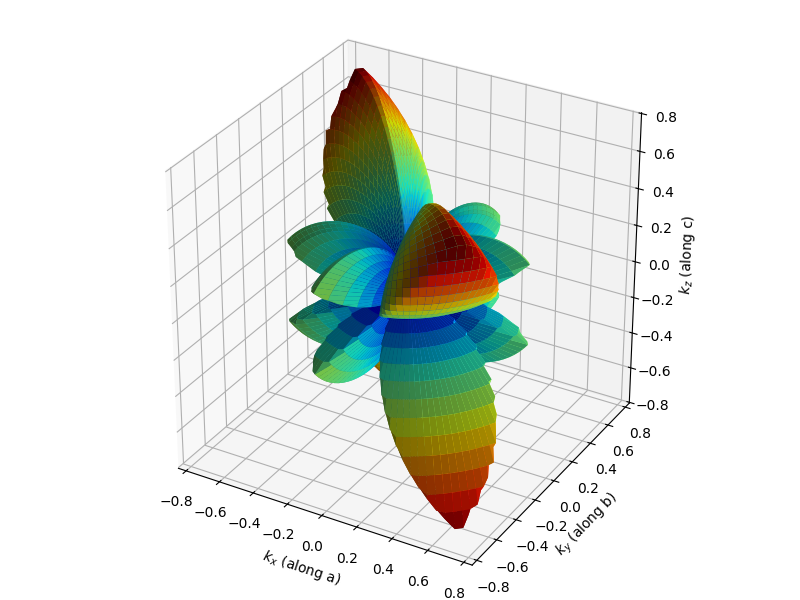

In [123]:
# Careful! This is hard to render if you have >1000 k points. In that case skip this cell and plot planes below.
%matplotlib widget
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_deformed, y_deformed, z_deformed,
                facecolors=plt.cm.jet((radius - radius.min()) / np.ptp(radius)),
                rstride=1, cstride=1, linewidth=0, antialiased=True)

ax.set_box_aspect([1, 1, 1])
ax.set_xlabel('$k_x$ (along a)')
ax.set_ylabel('$k_y$ (along b)')
ax.set_zlabel('$k_z$ (along c)')
plt.tight_layout()
plt.show()

[0. 1. 0.]
[-0.70710678  0.          0.70710678]


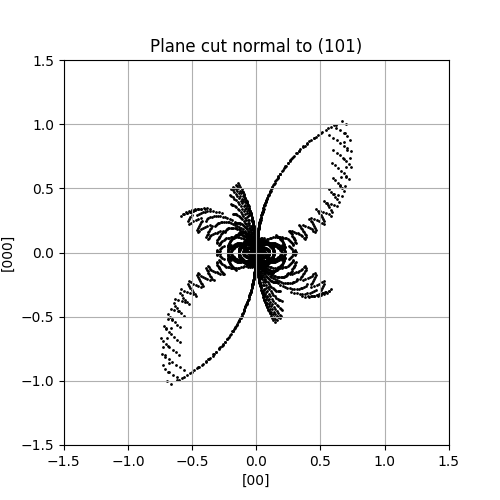

In [124]:
plot_plane_cut(x_deformed,y_deformed,z_deformed,[1,0,1])